<a href="https://colab.research.google.com/github/KamilBartosik/pySpark_Bundesliga_2000-2010_analysis/blob/main/pySpark_Bundesliga_2000_2010_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [76]:
#import findspark
#from pyspark import SparkContext
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
#from pyspark.sql.types import *
import matplotlib.pyplot as plt

In [77]:
spark = SparkSession \
        .builder \
        .appName("firstSpark") \
        .getOrCreate()

1. Who are the winners of the D1 division in the Germany Football Association 
    (Bundesliga) in the 2000-2010?

In [78]:
DATASET = "/content/gdrive/MyDrive/MachineLearning/Datasets/Bundesliga_2000-2010"
df_matches = spark.read.csv(DATASET, header=True)

In [79]:
df_matches.show(5)

+--------+---+------+----------+-------------+--------------+----+----+---+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+----------+-------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|   1|   3|  A|
+--------+---+------+----------+-------------+--------------+----+----+---+
only showing top 5 rows



In [80]:
old_cols = df_matches.columns[-3:]
new_cols = ["HomeTeamGoals", "AwayTeamGoals", "FinalResult"]
old_new_cols = [*zip(old_cols, new_cols)]
for old_col, new_col in old_new_cols:
    df_matches = df_matches.withColumnRenamed(old_col, new_col)

df_matches.show(5)

+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|HomeTeamGoals|AwayTeamGoals|FinalResult|
+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|            2|            1|          H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|            0|            1|          A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|            1|            1|          D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|            2|            1|          H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|            1|            3|          A|
+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+
only showing top 5 rows



In [81]:
df_matches = df_matches \
            .withColumn("HomeTeamWin", when(col("FinalResult")=="H", 1).otherwise(0)) \
            .withColumn("AwayTeamWin", when(col("FinalResult")=="A", 1).otherwise(0)) \
            .withColumn("GameTie", when(col("FinalResult")=="D", 1).otherwise(0))
            
df_matches.show(5)

+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+-----------+-----------+-------+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|HomeTeamGoals|AwayTeamGoals|FinalResult|HomeTeamWin|AwayTeamWin|GameTie|
+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+-----------+-----------+-------+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|            2|            1|          H|          1|          0|      0|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|            0|            1|          A|          0|          1|      0|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|            1|            1|          D|          0|          0|      1|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|            2|            1|          H|          1|          0|      0|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe| 

In [82]:
bundesliga = df_matches \
            .filter((col('Div')=="D1") &
                    (col('Season')>=2000) &
                    (col('Season')<=2010))

In [83]:
home = bundesliga.groupBy('Season', 'HomeTeam') \
        .agg(sum("HomeTeamWin").alias("TotalHomeWin"),
             sum("AwayTeamWin").alias("TotalHomeLoss"),
             sum("GameTie").alias("TotalHomeTie"),
             sum("HomeTeamGoals").alias("HomeScoredGoals"),
             sum("AwayTeamGoals").alias("HomeAgainstGoals")) \
        .withColumnRenamed('HomeTeam', 'Team')

home.orderBy('Season').show(5)

+------+-------------+------------+-------------+------------+---------------+----------------+
|Season|         Team|TotalHomeWin|TotalHomeLoss|TotalHomeTie|HomeScoredGoals|HomeAgainstGoals|
+------+-------------+------------+-------------+------------+---------------+----------------+
|  2000|  Munich 1860|           8|            6|           3|           23.0|            25.0|
|  2000|Ein Frankfurt|           8|            6|           3|           26.0|            22.0|
|  2000|      Hamburg|           8|            3|           6|           33.0|            21.0|
|  2000|Hansa Rostock|           8|            4|           5|           22.0|            20.0|
|  2000|       Bochum|           5|            8|           4|           20.0|            28.0|
+------+-------------+------------+-------------+------------+---------------+----------------+
only showing top 5 rows



In [84]:
away = bundesliga.groupBy('Season', 'AwayTeam') \
        .agg(sum("AwayTeamWin").alias("TotalAwayWin"),
             sum("HomeTeamWin").alias("TotalAwayLoss"),
             sum("GameTie").alias("TotalAwayTie"),
             sum("AwayTeamGoals").alias("AwayScoredGoals"),
             sum("HomeTeamGoals").alias("AwayAgainstGoals")) \
        .withColumnRenamed('AwayTeam', 'Team')
        
away.orderBy('Season').show(5)

+------+-------------+------------+-------------+------------+---------------+----------------+
|Season|         Team|TotalAwayWin|TotalAwayLoss|TotalAwayTie|AwayScoredGoals|AwayAgainstGoals|
+------+-------------+------------+-------------+------------+---------------+----------------+
|  2000|  Munich 1860|           4|            8|           5|           20.0|            30.0|
|  2000|Ein Frankfurt|           2|           13|           2|           15.0|            46.0|
|  2000|      Hamburg|           2|           10|           5|           25.0|            37.0|
|  2000|Hansa Rostock|           4|           11|           2|           12.0|            27.0|
|  2000|       Bochum|           2|           13|           2|           10.0|            39.0|
+------+-------------+------------+-------------+------------+---------------+----------------+
only showing top 5 rows



In [85]:
window = ['Season']
window = Window.partitionBy(window).orderBy(col('Points').desc(), col('GoalDiff').desc())
table = home.join(away, ['Season', 'Team'], 'inner') \
    .withColumn('Win', col('TotalHomeWin') + col('TotalAwayWin')) \
    .withColumn('Tie', col('TotalHomeTie') + col('TotalAwayTie')) \
    .withColumn('Loss', col('TotalHomeLoss') + col('TotalAwayLoss')) \
    .withColumn('Points', col('Win')*3 + col('Tie')*1) \
    .withColumn('GoalsScored', col('HomeScoredGoals') + col('AwayScoredGoals')) \
    .withColumn('GoalsAgainst', col('HomeAgainstGoals') + col('AwayAgainstGoals')) \
    .withColumn('GoalDiff', col('GoalsScored') - col('GoalsAgainst')) \
    .drop('TotalHomeWin', 'TotalAwayWin', 'TotalHomeLoss', 'TotalAwayLoss') \
    .drop('TotalHomeTie', 'TotalAwayTie', 'HomeScoredGoals', 'AwayScoredGoals') \
    .drop('HomeAgainstGoals', 'AwayAgainstGoals') \
    .withColumn('TeamPosition', rank().over(window))
    
bundesliga_df = table.filter(col('TeamPosition') == 1).orderBy('Season')
bundesliga_df.toPandas()

,Season,Team,Win,Tie,Loss,Points,GoalsScored,GoalsAgainst,GoalDiff,TeamPosition
0,2000,Bayern Munich,19,6,9,63,62.0,37.0,25.0,1
1,2001,Dortmund,21,7,6,70,62.0,33.0,29.0,1
2,2002,Bayern Munich,23,6,5,75,70.0,25.0,45.0,1
3,2003,Werder Bremen,22,8,4,74,79.0,38.0,41.0,1
4,2004,Bayern Munich,24,5,5,77,75.0,33.0,42.0,1
5,2005,Bayern Munich,22,9,3,75,67.0,32.0,35.0,1
6,2006,Stuttgart,21,7,6,70,61.0,37.0,24.0,1
7,2007,Bayern Munich,22,10,2,76,68.0,21.0,47.0,1
8,2008,Wolfsburg,21,6,7,69,80.0,41.0,39.0,1
9,2009,Bayern Munich,20,10,4,70,72.0,31.0,41.0,1


In [86]:
bundesliga_df.groupby('Team').agg(count('Team').alias("TotalChampionships"),
                          avg('Points').alias('AvgPoints'),
                          avg('GoalDiff').alias('AvgGoalDiff'),
                          avg('Win').alias('AvgWin'),
                          avg('Loss').alias('AvgLoss'),
                          avg('Tie').alias('AvgTie')) \
    .orderBy(desc("TotalChampionships")).toPandas().round(1)

,Team,TotalChampionships,AvgPoints,AvgGoalDiff,AvgWin,AvgLoss,AvgTie
0,Bayern Munich,6,72.7,39.2,21.7,4.7,7.7
1,Dortmund,2,72.5,37.0,22.0,5.5,6.5
2,Werder Bremen,1,74.0,41.0,22.0,4.0,8.0
3,Wolfsburg,1,69.0,39.0,21.0,7.0,6.0
4,Stuttgart,1,70.0,24.0,21.0,6.0,7.0


2. Which teams have been relegated in the 2003 season?

In [87]:
relegated_df = table.filter((col('TeamPosition') == 16) |
                            (col('TeamPosition') == 17) |
                            (col('TeamPosition') == 18)).orderBy(asc('Season'), asc('TeamPosition'))
relegated_df.filter(col('Season') == 2003).toPandas()

,Season,Team,Win,Tie,Loss,Points,GoalsScored,GoalsAgainst,GoalDiff,TeamPosition
0,2003,Ein Frankfurt,9,5,20,32,36.0,53.0,-17.0,16
1,2003,Munich 1860,8,8,18,32,32.0,55.0,-23.0,17
2,2003,FC Koln,6,5,23,23,32.0,57.0,-25.0,18


3. Does Oktoberfest have any effect on the performance of the overall league?

In [88]:
oktoberfest = df_matches \
                .filter(col('Div') == 'D1') \
                .filter((col('Season') >= 2000) & (col('Season') <= 2010)) \
                .withColumn('Month', month(col('Date'))) \
                .groupby('Month') \
                .agg(sum(col('HomeTeamGoals') + col('AwayTeamGoals')).alias('Goals'),
                     sum('GameTie').alias('GameTie'),
                     count(col('FinalResult')).alias('Total')) \
                .withColumn('Goals_to_games_ratio', round(col('Goals')/col('Total'), 1)) \
                .withColumn('GameTie_to_games_ratio', round(col('GameTie')/col('Total'), 1))

oktoberfest.orderBy('Month').show()

+-----+------+-------+-----+--------------------+----------------------+
|Month| Goals|GameTie|Total|Goals_to_games_ratio|GameTie_to_games_ratio|
+-----+------+-------+-----+--------------------+----------------------+
|    1| 386.0|     27|  140|                 2.8|                   0.2|
|    2|1108.0|    110|  415|                 2.7|                   0.3|
|    3|1076.0|     96|  386|                 2.8|                   0.2|
|    4|1138.0|     90|  416|                 2.7|                   0.2|
|    5| 993.0|     65|  308|                 3.2|                   0.2|
|    7|  14.0|      2|    8|                 1.8|                   0.3|
|    8| 871.0|     82|  298|                 2.9|                   0.3|
|    9|1027.0|     91|  364|                 2.8|                   0.3|
|   10|1036.0|     81|  354|                 2.9|                   0.2|
|   11|1160.0|     92|  387|                 3.0|                   0.2|
|   12| 813.0|     91|  290|                 2.8|  

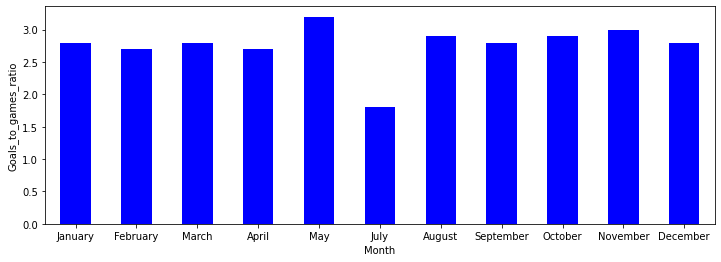

In [89]:
months_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months_numbers = list(range(1, 13))
months = dict(zip(months_numbers, months_names))

oktoberfest_df = oktoberfest.toPandas()
oktoberfest_df = oktoberfest_df.sort_values('Month')
oktoberfest_df = oktoberfest_df.replace({'Month': months})
oktoberfest_df.set_index('Month', drop=True, inplace=True)
oktoberfest_df['Goals_to_games_ratio'].plot.bar(rot=0, color='blue', figsize=(12, 4))
plt.ylabel('Goals_to_games_ratio')
plt.show()

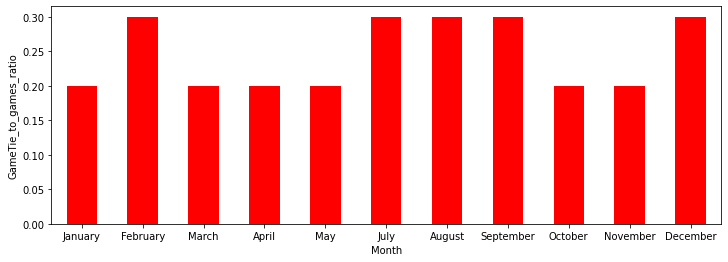

In [90]:
oktoberfest_df['GameTie_to_games_ratio'].plot.bar(rot=0, color='red', figsize=(12, 4))
plt.ylabel('GameTie_to_games_ratio')
plt.show()